In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

###### Read data

In [12]:
data = pd.read_csv('data_v4_addtext.csv')
data['date'] = data.date.map(lambda x: date(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2]) ))
data.columns

Index(['Unnamed: 0', '美食', '美食制作', '生活', '美食圈', '日常', '吃货', '美食侦探', '美食vlog',
       '吃播',
       ...
       'similiar_title餐厅', 'similiar_title烧烤', 'similiar_title海鲜',
       'similiar_title外卖', 'similiar_title新疆', 'created_iso_yr', 'created_mo',
       'created_mo_day', 'created_iso_wk', 'date'],
      dtype='object', length=313)

###### Parameters setting

In [13]:
cut_off_date_1 = date(2020,7,15)
cut_off_date_2 = date(2020,8,15)

###### Split Train，Valid, Test

In [16]:
test_idx = data.date > cut_off_date_2
val_idx = (cut_off_date_1 < data.date) & (data.date < cut_off_date_2)
print('test percentage:{:.3f}'.format((test_idx).sum() / len(data.date)))
print('valid percentage:{:.3f}'.format((val_idx).sum() / len(data.date)))
data.drop('date', axis = 1, inplace = True)

test percentage:0.180
valid percentage:0.154


###### Normalization

In [17]:
file_clean = pd.DataFrame()
for col in data.columns:
    if(col == "log_play"):
        file_clean[col] = data[col].values
    else:
        file_clean[col] = preprocessing.scale(data[col])

In [19]:
test_df = file_clean[test_idx == True]
val_df = file_clean[val_idx == True]
train_df = file_clean[(test_idx == False) & (val_idx == False)]

x_train = train_df.drop(columns = "log_play")
x_test = test_df.drop(columns = "log_play")
x_val = val_df.drop(columns = "log_play")
y_train = train_df["log_play"]
y_test = test_df["log_play"]
y_val = val_df["log_play"]
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((9879, 311), (2663, 311), (2278, 311), (9879,), (2663,), (2278,))

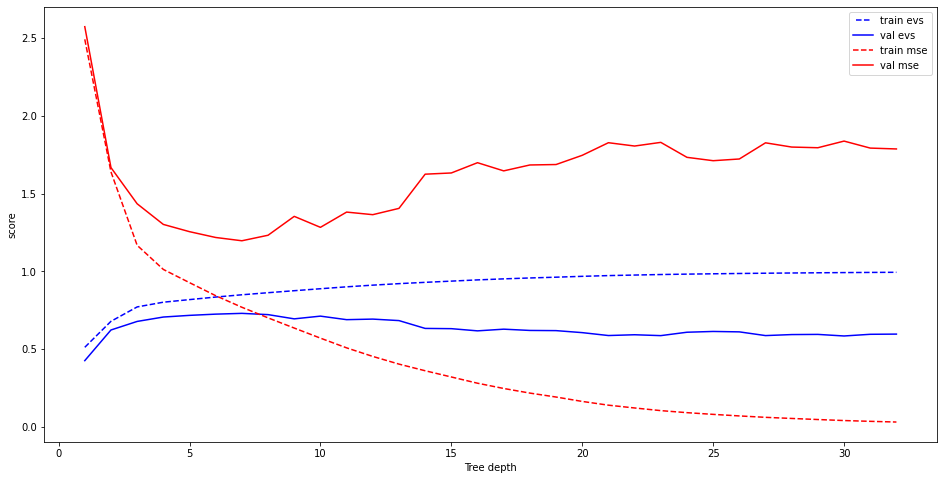

best depth is 7.0 with mse 1.1963821850214464 and R2 0.7298968861140495


In [20]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_evs = []
train_mse = []
val_evs = []
val_mse = []
best_depth = -1
best_mse = 999
best_evs = 999
for max_depth in max_depths:
   dt1 = DecisionTreeRegressor(max_depth=max_depth)
   dt1.fit(x_train, y_train)
   train_pred = dt1.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = dt1.predict(x_val)
   evs_val = explained_variance_score(y_val, y_pred)
   mse_val = mean_squared_error(y_val, y_pred)
   val_evs.append(evs_val)
   val_mse.append(mse_val)
   if mse_val < best_mse:
       best_mse = mse_val
       best_depth = max_depth
       best_evs = evs_val
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(max_depths, train_evs, '--b', label="train evs")
line2, = plt.plot(max_depths, val_evs, '-b', label="val evs")
line3, = plt.plot(max_depths, train_mse, '--r', label="train mse")
line4, = plt.plot(max_depths, val_mse, '-r', label="val mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('Tree depth')
plt.show()
print("best depth is "+str(best_depth)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

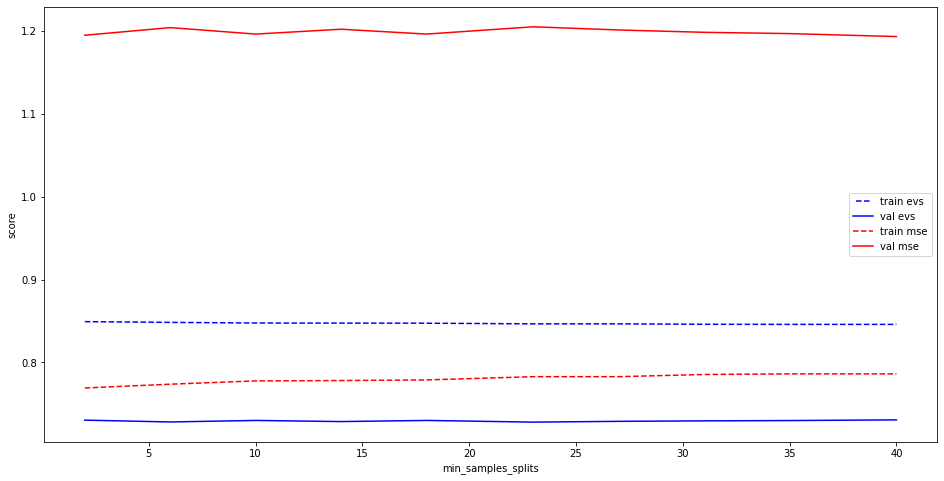

best min_samples_split is 40 with mse 1.1936250063124658 and R2 0.730604732199752


In [21]:
min_samples_splits = np.linspace(2, 40, 10, dtype = int)
train_evs = []
train_mse = []
val_evs = []
val_mse = []
best_min_samples_split = -1
best_mse = 999
best_evs = 999
for min_samples_split in min_samples_splits:
   dt2 = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=min_samples_split)
   dt2.fit(x_train, y_train)
   train_pred = dt2.predict(x_train)
   evs_train = explained_variance_score(y_train, train_pred)
   mse_train = mean_squared_error(y_train, train_pred)
   train_evs.append(evs_train)
   train_mse.append(mse_train)
   y_pred = dt2.predict(x_val)
   evs_val = explained_variance_score(y_val, y_pred)
   mse_val = mean_squared_error(y_val, y_pred)
   val_evs.append(evs_val)
   val_mse.append(mse_val)
   if mse_val < best_mse:
       best_min_samples_split = min_samples_split
       best_mse = mse_val
       best_evs = evs_val
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(16,8))
line1, = plt.plot(min_samples_splits, train_evs, '--b', label="train evs")
line2, = plt.plot(min_samples_splits, val_evs, '-b', label="val evs")
line3, = plt.plot(min_samples_splits, train_mse, '--r', label="train mse")
line4, = plt.plot(min_samples_splits, val_mse, '-r', label="val mse")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('min_samples_splits')
plt.show()
print("best min_samples_split is "+str(best_min_samples_split)+" with mse "+str(best_mse)+" and R2 "+str(best_evs))

#### Use train and valid data to train the best model and the test

In [22]:
dt3 = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_min_samples_split)

train_all_df = file_clean[test_idx == False]
x_train_all = train_all_df.drop(columns = "log_play")
y_train_all = train_all_df["log_play"]

dt3.fit(x_train_all, y_train_all)

y_pred = dt3.predict(x_test)
explained_variance_score(y_test, y_pred), mean_squared_error(y_test, y_pred)

(0.48336076177406206, 2.4017156990263535)

In [23]:
file_fi = pd.DataFrame({'importance_value': dt3.feature_importances_}, index=x_train.columns).sort_values(by='importance_value', ascending=False)
file_fi[:20]

,importance_value
last_3month_play,0.949411
Unnamed: 0,0.016543
length,0.008935
life_ratio,0.004676
last_3month_count,0.002492
food_ratio,0.002375
similiar_desc吃货,0.001894
created_iso_wk,0.001562
similiar_desc陕西,0.001187
similiar_desc放入,0.001006


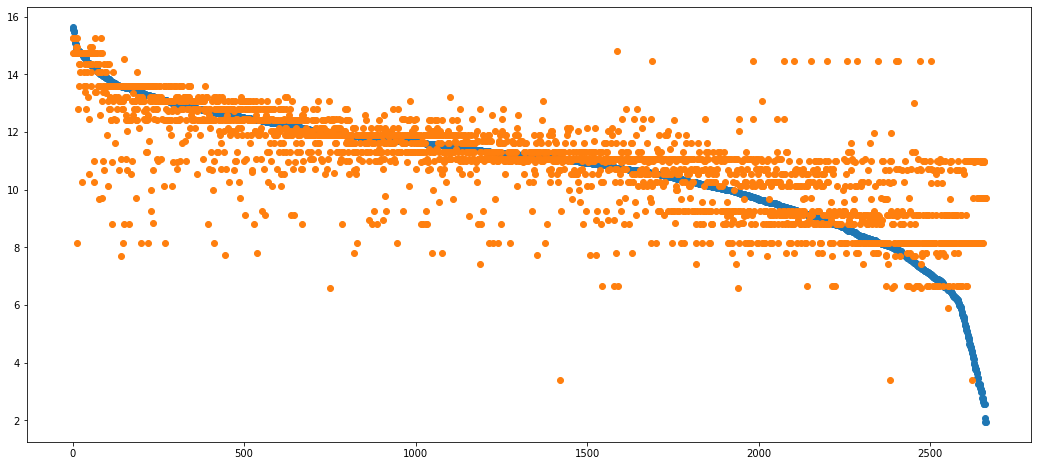

In [24]:
file_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).sort_values(by='y_test', ascending=False)
plt.figure(figsize=(18,8))
plt.scatter(range(file_pred.shape[0]), file_pred.y_test)
plt.scatter(range(file_pred.shape[0]), file_pred.y_pred)